# PLS Regression to Predict Age

Note: The resources used while building this model are as follows:
1. https://nirpyresearch.com/partial-least-squares-regression-python/

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.cross_decomposition import PLSRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sb

# Data

In [3]:
data = pd.read_csv("./Volumetric_features.csv")

data_features = pd.DataFrame(data, columns = data.columns[:-1])
data_features = data_features.drop(['S.No','Age'], axis=1)

data_features.head()
data_features.describe()

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness,BrainSegVolNotVent.2,eTIV.1
count,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,...,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4.226000e+03,4.226000e+03
mean,13370.040795,574.849716,14646.696711,52002.811571,7164.947539,3337.653526,4505.158755,1958.214458,1418.947373,1797.243469,...,2.117151,2.655624,2.429779,2.684327,3.555803,2.288283,2.846123,2.372266,1.085468e+06,1.514925e+06
std,9194.928348,594.590387,2622.868798,6378.435917,1207.229615,502.352001,713.658580,287.139826,635.143286,583.220321,...,0.174228,0.207942,0.185543,0.275245,0.332094,0.269851,0.195038,0.146944,1.248881e+05,1.651798e+05
min,2204.100000,0.000000,6920.100000,29911.800000,4145.400000,1035.600000,2294.000000,851.900000,39.700000,371.900000,...,1.499000,1.563000,1.345000,1.655000,1.940000,1.176000,1.533000,1.483290,6.279600e+05,8.329815e+05
25%,7031.625000,243.200000,12909.875000,47359.675000,6239.425000,2984.500000,4008.125000,1764.700000,941.825000,1408.050000,...,2.002250,2.521000,2.309000,2.510000,3.360000,2.105000,2.720000,2.274935,9.957585e+05,1.404471e+06
50%,10669.950000,385.800000,14277.000000,51333.650000,7032.150000,3294.050000,4438.100000,1940.100000,1225.450000,1683.850000,...,2.130000,2.665000,2.440500,2.685000,3.586500,2.297000,2.851000,2.383375,1.075919e+06,1.511767e+06
75%,17332.650000,720.825000,15959.725000,56287.775000,7977.400000,3655.125000,4963.025000,2128.000000,1780.225000,2044.525000,...,2.245000,2.808000,2.562750,2.851000,3.790000,2.476000,2.975000,2.483143,1.168888e+06,1.625445e+06
max,79812.500000,7533.800000,35042.500000,79948.200000,13008.300000,6018.000000,8446.100000,4357.700000,4461.600000,5312.400000,...,2.671000,3.240000,2.996000,3.928000,4.487000,3.123000,3.482000,2.803730,1.545129e+06,2.075213e+06


# Training

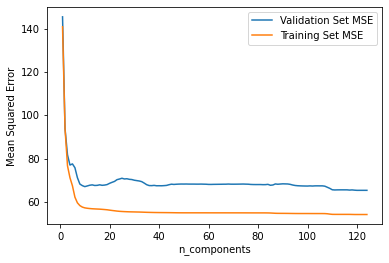

Min MSE: 65.32844981103128at n_components=120


In [4]:
# Split out train data, 80%, and the rest, 20%
X_train, X_rest, Y_train, Y_rest = train_test_split(data_features, data['Age'], test_size=0.20, random_state=33)
# Spit out validate data, 15% (of total, 75% of X_rest), and test, 5% (of total, 25% of rest)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_rest, Y_rest, test_size=0.25, random_state=33)

n_components = range(1,125)
train_accuracy = np.empty(len(n_components))
validation_accuracy = np.empty(len(n_components))

for i, components in enumerate(n_components):
    model = PLSRegression(n_components = components)
    model.fit(X_train, Y_train)
    
    Y_pred_train = model.predict(X_train)
    Y_pred_validate = model.predict(X_validate)
    
    train_accuracy[i] = metrics.mean_squared_error(Y_train, Y_pred_train)
    validation_accuracy[i] = metrics.mean_squared_error(Y_validate, Y_pred_validate)

plt.plot(n_components, validation_accuracy, label='Validation Set MSE')
plt.plot(n_components, train_accuracy, label='Training Set MSE')

plt.legend()
plt.xlabel('n_components')
plt.ylabel('Mean Squared Error')
plt.show()

mse_res = np.array(validation_accuracy)

print("Min MSE: " + str(min(mse_res)) + "at n_components=" + str(list(mse_res).index(min(mse_res)) + 1))

# Testing

In [8]:
pls = PLSRegression(n_components=120)
pls.fit(X_train, Y_train)
Y_pred = pls.predict(X_test)

print("Explained variance: " + str(metrics.explained_variance_score(Y_test, Y_pred)))
print("Max Error: " + str(metrics.max_error(Y_test, Y_pred)))
print("Mean absolute error: " + str(metrics.mean_absolute_error(Y_test, Y_pred)))
print("Mean squared error: " + str(metrics.mean_squared_error(Y_test, Y_pred)))
print("Root Mean squared error: " + str(metrics.mean_squared_error(Y_test, Y_pred, squared=False)))
print("R2: " + str(metrics.r2_score(Y_test, Y_pred)))



Explained variance: 0.8262360743325828
Max Error: 34.850748584523046
Mean absolute error: 6.480442424054795
Mean squared error: 68.28701970207239
Root Mean squared error: 8.26359605148221
R2: 0.8258378422623844
